### Profiling reduction

02/08/2022

Test sets: 
 - system solving
 - biomodels
 - doi

#### Imports

In [256]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [258]:
import os
import sys

In [259]:
import pandas as pd
sys.path.append('/home/ademin/reduce3/reduce-algebra-code/generic/rbench')

In [260]:
import rbench as rb

### Parsing & Cleaning

In [419]:
profile = pd.read_csv("./putin.csv")
profile = profile.set_index("system")
profile = profile[~profile.index.duplicated(keep='first')]
len(profile)

195

In [264]:
profile.head()

,first,second,total
system,,,
ku10,10,10,50
caprasse,30,10,70
noon5,0,0,90
root9,0,0,110
eco7,640,70,760


array([[<AxesSubplot:title={'center':'first'}>,
        <AxesSubplot:title={'center':'second'}>],
       [<AxesSubplot:title={'center':'total'}>, <AxesSubplot:>]],
      dtype=object)

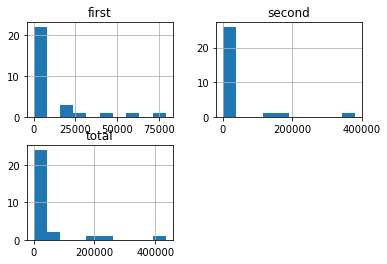

In [265]:
profile[profile["total"] > 100.0].hist()

In [436]:
f5 = rb.read_filetree('./f5-full', 'f5').select('boot').deselect(['heapsize', 'valid'])
groebner = rb.read_filetree('./groebner-full', 'groebner').select('boot').deselect(['heapsize', 'valid'])

In [437]:
groebner.index = [s[s.rfind("/")+1:] for s in groebner.index]
f5.index = [s[s.rfind("/")+1:] for s in f5.index]

In [438]:
assert len(groebner) == len(f5)

In [440]:
combo = f5.join(groebner, how='inner')
combo.head()

f5                                \
                               start_boot cpu_boot gc_boot sigxcpu_boot   
Arnborg         2022-08-02 08:59:22+02:00     0.03    0.01          NaN   
Arnborg         2022-08-02 08:59:22+02:00     0.03    0.01          NaN   
Arnborg         2022-08-02 08:51:26+02:00      NaN     NaN        600.0   
Arnborg         2022-08-02 08:51:26+02:00      NaN     NaN        600.0   
BIOMD0000000002 2022-08-02 08:40:51+02:00     0.17    0.01          NaN   

                                                           groebner           \
                                 end_boot                start_boot cpu_boot   
Arnborg         2022-08-02 08:59:22+02:00 2022-08-02 09:24:50+02:00     0.05   
Arnborg         2022-08-02 08:59:22+02:00 2022-08-02 09:24:41+02:00      NaN   
Arnborg         2022-08-02 09:01:15+02:00 2022-08-02 09:24:50+02:00     0.05   
Arnborg         2022-08-02 09:01:15+02:00 2022-08-02 09:24:41+02:00      NaN   
BIOMD0000000002 2022-08-02 08:40:52+02:00 2022-08-02 09:12:37+02:00     1.24   

                                                                
                gc_boot sigxcpu_boot                  end_boot  
Arnborg            0.01          NaN 2022-08-02 09:24:50+02:00  
Arnborg             NaN        600.0 2022-08-02 09:34:16+02:00  
Arnborg            0.01          NaN 2022-08-02 09:24:50+02:00  
Arnborg             NaN        600.0 2022-08-02 09:34:16+02:00  
BIOMD0000000002    0.00          NaN 2022-08-02 09:12:39+02:00

In [441]:
f5faster = combo[("f5", "cpu_boot")] < combo[("groebner", "cpu_boot")]
f5faster = f5faster[~f5faster.index.duplicated(keep='first')]
f5faster = f5faster.loc[profile.index] 

In [442]:
c4 = combo[~combo.index.duplicated(keep='first')].loc[f5faster.index]
redtimes4 =  3 * profile["first"] / 4
f5faster4 = (c1[("f5", "cpu_boot")] - redtimes4/1000) < c1[("groebner", "cpu_boot")]
f5faster4.head()

system
ku10        False
caprasse    False
noon5        True
root9        True
eco7         True
dtype: bool

In [443]:
assert len(f5faster) == len(profile) 

In [444]:
profile["f5_is_faster"] = f5faster

In [445]:
profile4 = profile.copy()
profile4["f5_is_faster"] = f5faster4

In [446]:
profile.head()

,first,second,total,f5_is_faster
system,,,,
ku10,10,10,50,False
caprasse,30,10,70,False
noon5,0,0,90,True
root9,0,0,110,True
eco7,640,70,760,False


In [447]:
profile1 = profile.copy()
profile2 = profile.copy()
midx1 = pd.MultiIndex(levels=[["f5_faster"], ["first", "second", "total", "f5_is_faster"]],
                    codes=[[0, 0, 0,0], [0, 1, 2,3]])
midx2 = pd.MultiIndex(levels=[["groebner_faster"], ["first", "second", "total", "f5_is_faster"]],
                    codes=[[0, 0, 0,0], [0, 1, 2,3]])
profile1.columns = midx1
profile2.columns = midx2

profile41 = profile4.copy()
profile42 = profile4.copy()
midx1 = pd.MultiIndex(levels=[["f5_faster"], ["first", "second", "total", "f5_is_faster"]],
                    codes=[[0, 0, 0,0], [0, 1, 2,3]])
midx2 = pd.MultiIndex(levels=[["groebner_faster"], ["first", "second", "total", "f5_is_faster"]],
                    codes=[[0, 0, 0,0], [0, 1, 2,3]])
profile41.columns = midx1
profile42.columns = midx2

In [450]:
merged4 = pd.concat([profile41, profile42], axis=1)
merged4.head()

idx = merged4[merged4[('f5_faster', 'f5_is_faster')] == 0].index
rows = merged4.loc[idx]
rows[[('f5_faster', 'first'), ('f5_faster', 'second')]] = np.nan
merged4.loc[idx] = rows

idx = merged4[merged4[('groebner_faster', 'f5_is_faster')] == 1].index
rows = merged4.loc[idx]
rows[[('groebner_faster', 'first'), ('groebner_faster', 'second')]] = np.nan
merged4.loc[idx] = rows

merged = pd.concat([profile1, profile2], axis=1)
merged.head()

idx = merged[merged[('f5_faster', 'f5_is_faster')] == 0].index
rows = merged.loc[idx]
rows[[('f5_faster', 'first'), ('f5_faster', 'second')]] = np.nan
merged.loc[idx] = rows

idx = merged[merged[('groebner_faster', 'f5_is_faster')] == 1].index
rows = merged.loc[idx]
rows[[('groebner_faster', 'first'), ('groebner_faster', 'second')]] = np.nan
merged.loc[idx] = rows

merged.head()

f5_faster                           groebner_faster               \
             first second total f5_is_faster           first second total   
system                                                                      
ku10           NaN    NaN    50        False            10.0   10.0    50   
caprasse       NaN    NaN    70        False            30.0   10.0    70   
noon5          0.0    0.0    90         True             NaN    NaN    90   
root9          0.0    0.0   110         True             NaN    NaN   110   
eco7           NaN    NaN   760        False           640.0   70.0   760   

                       
         f5_is_faster  
system                 
ku10            False  
caprasse        False  
noon5            True  
root9            True  
eco7            False

In [451]:
rbmerged = rb.analytics.RbDataFrame(merged)

In [452]:
profile

,first,second,total,f5_is_faster
system,,,,
ku10,10,10,50,False
caprasse,30,10,70,False
noon5,0,0,90,True
root9,0,0,110,True
eco7,640,70,760,False
...,...,...,...,...
Integ1,20,40,890,False
CycRoot,100,130,2570,True
ParCurv,0,0,0,False


In [500]:
profile_50 = profile[profile["total"] > 50.]
profile_100 = profile[profile["total"] > 100.]
profile_1000 = profile[profile["total"] > 1000.]

In [517]:
percentages = pd.DataFrame(data = np.array([profile_100["first"]/profile_100["total"], profile_100["second"]/profile_100["total"]]).T, columns=["first reduction", "second reduction"])
percentages.index = profile_100.index

### Results

Table of time distributions between the time spent in the first and the second reduction out of total time spent  

In [519]:
percentages

,first reduction,second reduction
system,,
root9,0.000000,0.000000
eco7,0.842105,0.092105
root12,0.000000,0.000000
root11,0.000000,0.000000
noon6,0.142857,0.271429
katsura6,0.447552,0.503497
root10,0.000000,0.000000
cassou,0.349658,0.547657
noon7,0.180807,0.321280


mean, median:

In [520]:
percentages.describe()

,first reduction,second reduction
count,29.000000,29.000000
mean,0.366817,0.272885
std,0.291332,0.255459
min,0.000000,0.000000
25%,0.103631,0.092105
50%,0.349658,0.234291
75%,0.617021,0.325658
max,0.934831,0.877918


#### Time distribution (on average)


over all models

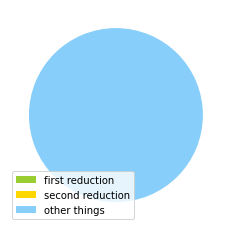

In [503]:
c1,c2 = (profile["first"] / profile["total"]).median(), (profile["second"] / profile["total"]).median()
c3 = 1 - c1 - c2
patches, texts = plt.pie([c1,c2,c3], colors=['yellowgreen', 'gold', 'lightskyblue'], startangle=90)
plt.legend(patches, ["first reduction", "second reduction", "other things"], loc="best")

over all models that took at least 100 ms to run:

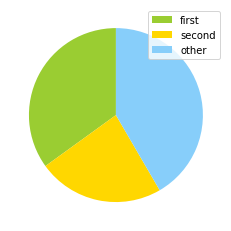

In [504]:
c1,c2 = (profile_100["first"] / profile_100["total"]).median(), (profile_100["second"] / profile_100["total"]).median()
c3 = 1 - c1 - c2
patches, texts = plt.pie([c1,c2,c3], colors=['yellowgreen', 'gold', 'lightskyblue'], startangle=90)
plt.legend(patches, ["first", "second", "other"], loc="best")

over all models that took at least 1000 ms to run

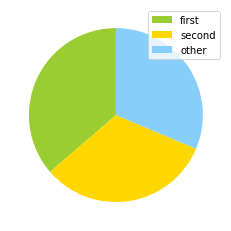

In [505]:
c1,c2 = (profile_1000["first"] / profile_1000["total"]).median(), (profile_1000["second"] / profile_1000["total"]).median()
c3 = 1 - c1 - c2
patches, texts = plt.pie([c1,c2,c3], colors=['yellowgreen', 'gold', 'lightskyblue'], startangle=90)
plt.legend(patches, ["first", "second", "other"], loc="best")

#### First reduction vs. Second reduction

(in milliseconds)

 - GREEN  - f5 is faster
 - VIOLET - groebner is faster

<AxesSubplot:xlabel='first', ylabel='second'>

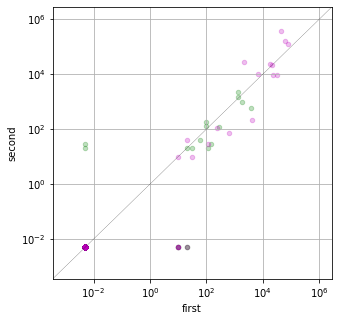

In [464]:
rbmerged.plot.scatter2(x="first", y ="second", c1="f5_faster", c2="groebner_faster")

#### only dots where f5 is faster

<AxesSubplot:xlabel='first', ylabel='second'>

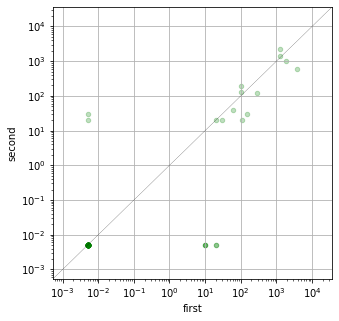

In [454]:
rbmerged[rbmerged["f5_faster", "f5_is_faster"]].plot.scatter2(x="first", y ="second", c1="f5_faster", c2="groebner_faster")

#### only dots where f5 is slower

<AxesSubplot:xlabel='first', ylabel='second'>

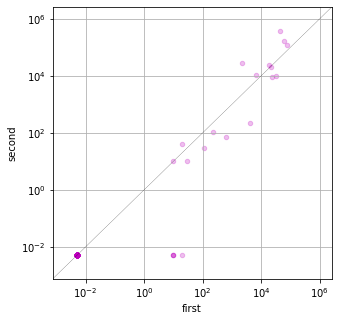

In [455]:
rbmerged[rbmerged["f5_faster", "f5_is_faster"] == False].plot.scatter2(x="first", y ="second", c1="f5_faster", c2="groebner_faster")

#### What happens if we speed up the first reduction by a factor of 4

In [465]:
print(f"We are faster on {sum(f5faster)} models.\nWith a 4 times speed up of first reduction we will be faster on {sum(f5faster4)} models.")

We are faster on 77 models.
With a 4 times speed up of first reduction we will be faster on 82 models.


<AxesSubplot:xlabel='first', ylabel='second'>

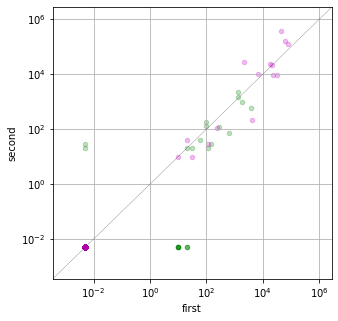

In [466]:
rb.analytics.RbDataFrame(merged4).plot.scatter2(x="first", y ="second", c1="f5_faster", c2="groebner_faster")

###  Reductions frequency diagrams

first reduction / total time histogram for models that took more than 50ms to run

<AxesSubplot:ylabel='Frequency'>

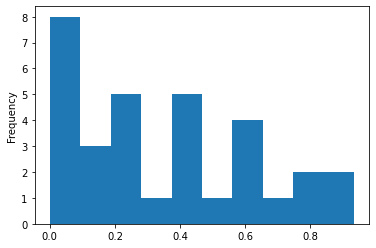

In [469]:
(profile_50["first"] / profile_50["total"]).plot.hist()

#### F5 vs. groebner

<AxesSubplot:xlabel='groebner', ylabel='f5'>

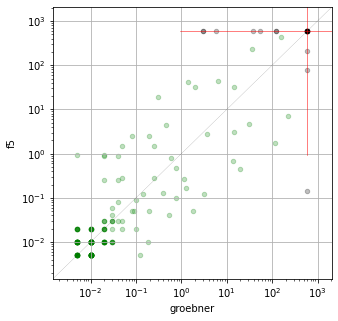

In [373]:
combo.plot.scatter1(x='groebner', y='f5', c='cpu_boot')

([<matplotlib.patches.Wedge at 0x7f90d6587430>,
 [Text(0.7778174593052024, 0.7778174593052023, ''),
  Text(-0.7778174593052025, -0.7778174593052023, '')])

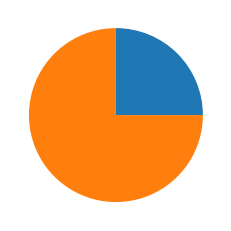

In [381]:
plt.pie([1, 3])

In [323]:
combo[[('f5', 'cpu_boot'), ('groebner', 'cpu_boot')]].describe()

,f5,groebner
,cpu_boot,cpu_boot
count,216.000000,222.000000
mean,5.394259,4.507613
std,36.868006,23.457453
min,0.000000,0.000000
25%,0.007500,0.010000
50%,0.010000,0.010000
75%,0.030000,0.030000
max,432.820000,227.290000
